# Capital Management

## The Kelly Criterion in a Binomial Setting

In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import cufflinks as cf
from pylab import plt

In [2]:
np.random.seed(1000)
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [3]:
p = 0.55    # fixes the probability for heads
f = p - (1 - p)    # calculates the optimal fraction accroding to the Kelly criterion
f

0.10000000000000009

In [4]:
I = 50  # the number of series to be simulated
n = 100 # the number of trials per series

In [5]:
def run_simulation(f):
    c = np.zeros((n, I))    # instantiates an ndarray object to store the simulation results
    c[0] = 100  # initializes the starting capital with 100
    for i in range(I):  # outer loop for the series simulations
        for t in range(1, n):   # inner loop for series itself
            o = np.random.binomial(1, p)    # simulates the tossing of a coin
            if o > 0:   # if 1, i.e., heads ...
                c[t, i] = (1 + f) * c[t-1, i]   # ... then add the win to the capital
            else:   # if 0, i.e., tails ...
                c[t, i] = (1 - f) * c[t-1, i]   # ... then substract the loss from the capital
    return c

c_1 = run_simulation(f) # runs the simulation
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]])

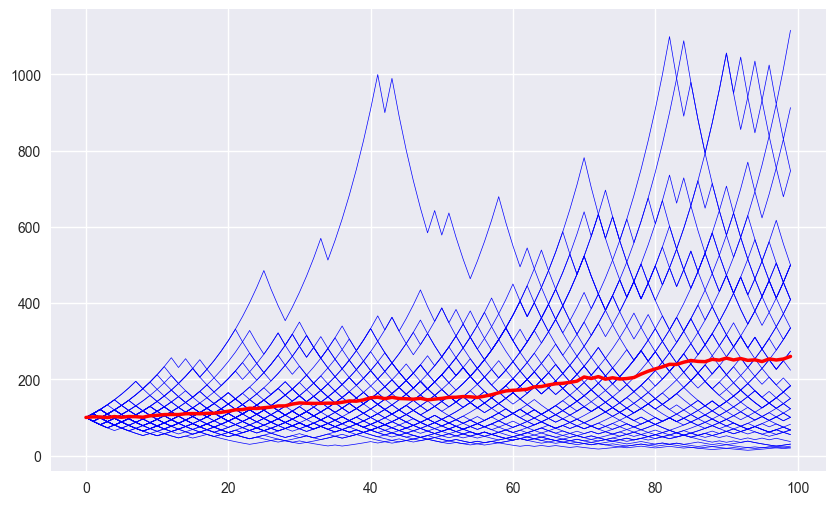

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)  # plots all 50 series
plt.plot(c_1.mean(axis=1), 'r', lw=2.5);    # plots the average over all 50 series

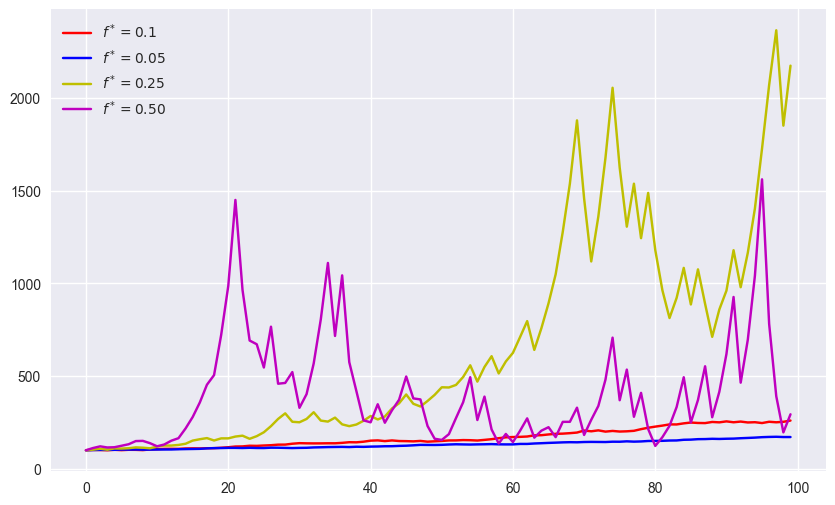

In [9]:
c_2 = run_simulation(0.05)  # simulation with f = 0.05
c_3 = run_simulation(0.25)  # simulation with f = 0.25
c_4 = run_simulation(0.50)  # simulation with f = 0.50

plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f^*=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f^*=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f^*=0.50$')
plt.legend(loc=0)

## The Kelly Criterion for Stocks and Indices

In [10]:
raw = pd.read_csv('/Users/cherongtian/Desktop/PythonforFinance/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)
symbol = '.SPX'
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data.tail()

,.SPX,returns
Date,,
2018-06-25,2717.07,-0.013820
2018-06-26,2723.06,0.002202
2018-06-27,2699.63,-0.008642
2018-06-28,2716.31,0.006160
2018-06-29,2718.37,0.000758


In [11]:
mu = data.returns.mean() * 252  # calculates the annualized return
mu

0.09898579893004976

In [14]:
sigma = data.returns.std() * 252 ** 0.5    # calculates the annualized volatility
sigma

0.1488567510081967

In [15]:
r = 0.0    # sets the risk-free rate to 0 (simplicity)
f = (mu - r) / sigma ** 2   # calculates the optimal Kelly fraction to be invested in the strategy
f

4.4672043679706865

In [17]:
equs = []
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1   # generates a new column for equity and sets the initial value to 1
    data[cap] = data[equ] * f   # generates a new column for capital and sets the initial value to 1 f*

    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]    # picks the right DatetimeIndex value for the previous values
        data.loc[t, cap] = data.loc[t_1, cap] * np.exp(data['returns'].loc[t])  
        # calculates the new captial position given the return

        data.loc[t, equ] = data.loc[t, cap] - data.loc[t_1, cap] + data.loc[t_1, equ]
        # adjusts the equity value according to the capital position performance

        data.loc[t, cap] = data.loc[t, equ] * f
        # adjusts the capital position given the new equity position and the fixed leverage ratio

kelly_strategy(f * 0.50)    # simulates the Kelly criterion-based strategy for half of f ...
kelly_strategy(f * 0.66)    # ... for two-thirds of f ...
kelly_strategy(f)           # ... and for f itself

print(data[equs].tail())

/var/folders/kx/tt33d8bd3t36vq3mm79tshdh0000gn/T/ipykernel_57220/2014334002.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0012184856879518' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/kx/tt33d8bd3t36vq3mm79tshdh0000gn/T/ipykernel_57220/2014334002.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0016084011080966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/kx/tt33d8bd3t36vq3mm79tshdh0000gn/T/ipykernel_57220/2014334002.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0024369713759036' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



            equity_2.23  equity_2.95  equity_4.47
Date                                             
2018-06-25     4.707070     6.367340     8.794342
2018-06-26     4.730248     6.408727     8.880952
2018-06-27     4.639340     6.246147     8.539593
2018-06-28     4.703365     6.359932     8.775296
2018-06-29     4.711332     6.374152     8.805026


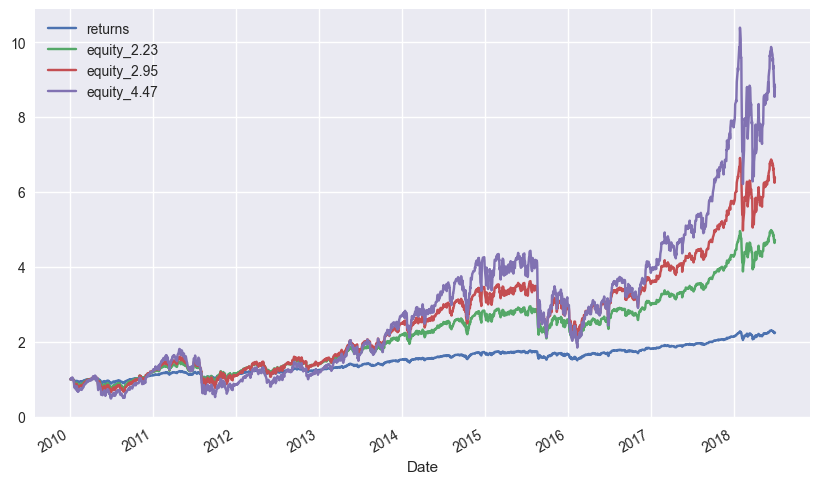

In [18]:
ax = data['returns'].cumsum().apply(np.exp).plot(legend=True, figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);

# ML-Based Trading Strategy

## Vectorized Backtesting

In [21]:
import fxcmpy
import pkg_resources

version = pkg_resources.get_distribution("fxcmpy").version
print(f"fxcmpy version: {version}")

fxcmpy version: 0.0.0.1
